# Strategy Based on Predicting the Direction of the Volume

Consider the imbalance volume direction as a boolean variable, construct a Machine Learning classification model to predict
the direction of the imbalance volume. Then, based on that prediction we have the following

- Trading Rule: 
    - if the direction is negative then we buy the spread.
    - else if the direction is positive then we sell the spread.

In [1]:
import pandas as pd
import numpy as np
import math
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

from AnalyticsModules.cleandata import CleanData
from AnalyticsModules.correlation import ClassicCorrelation
from BackTestModules.Strategy.PredictionML import ForestTrading

import warnings 

warnings.filterwarnings('ignore')


%load_ext autoreload
%autoreload 2

## Data Preparation and Feature Enginering

In [2]:
data = pd.read_csv('data/DOLCE.csv', delimiter = ';', decimal = ',', parse_dates=True, index_col='time')['2021-03-24':]
raw_imb = CleanData('data/imb_volumeUK.csv', 'imbalance volume').data.resample('H').mean()[data.index[0]: data.index[-1]]
cons_uk = CleanData('data/cons_uk.csv', 'consumption uk').data[data.index[0]: data.index[-1]]

In [3]:
data['imb_vol'] = raw_imb.values
data['cons'] = cons_uk.values

In [4]:
data.drop(columns = 'sell_price', inplace = True)
data.rename(columns = {'buy_price': 'imb_uk'}, inplace = True)

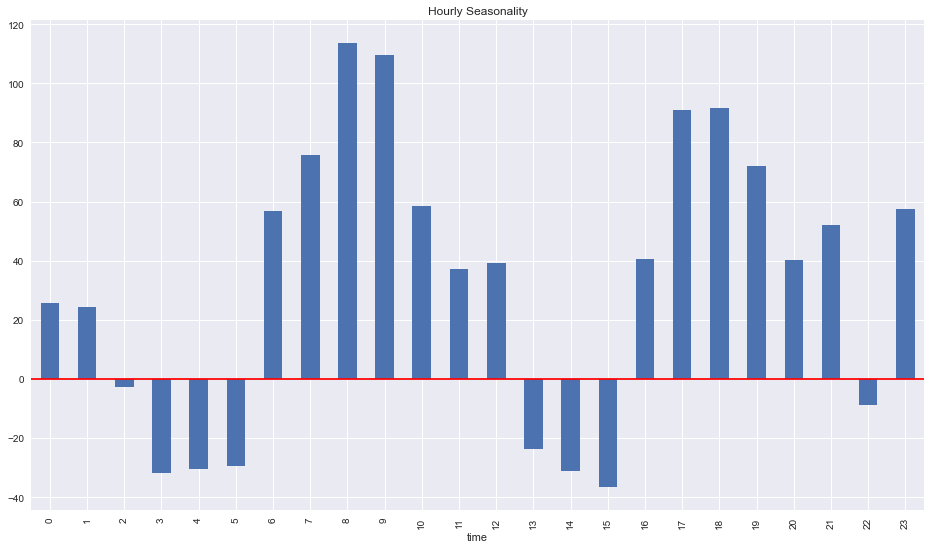

In [5]:
data.imb_vol.groupby(data.imb_vol.index.hour).mean().plot(figsize = (16,9), kind = 'bar',
                                                          title = 'Hourly Seasonality',
                                                          grid = True)
plt.axhline(0, color = 'r')
plt.show()

In [6]:
dummies = pd.get_dummies(data[['imb_vol']].index.hour.tolist()).astype(float)

type1 = [f'0{i}' for i in range(0,10)]
type2 = [f'{i}' for i in range(10,24)]

cols = [*type1, *type2]

dummies.columns = cols

neg_cols = ['01', '03', '04', '05', '13', '14', '15', '22']

for col in neg_cols:
    
    dummies.loc[dummies[col] != 0.0, col] = -1
    
dummies.set_index(data.index, drop = True, inplace = True)

In [7]:
direction = np.where(data.imb_vol > 0, 1, 0)

data['vol_dir'] = direction
data['spread'] = data.imb_uk.sub(data.spot_uk)

In [8]:
featured_data = pd.concat([dummies, data], axis = 1)
featured_data.fillna(method = 'ffill', limit = 1, inplace = True)

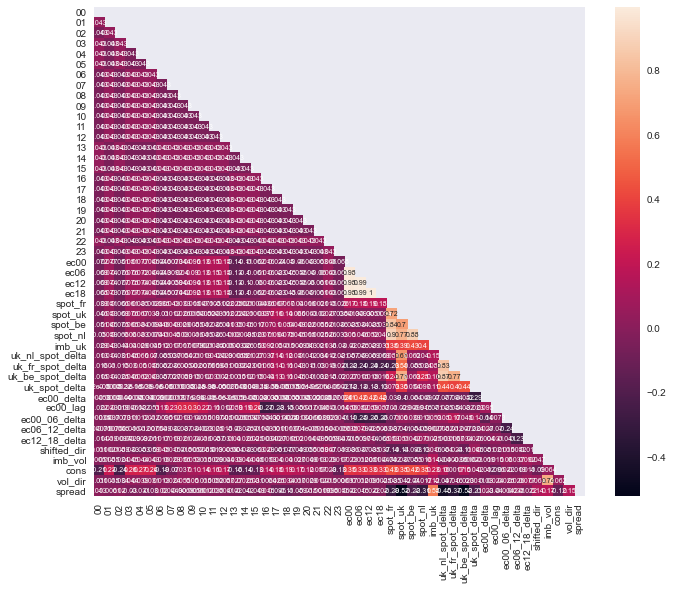

In [9]:
corr = ClassicCorrelation(featured_data, method = 'pearson')

corr.sample_correlation()


In [10]:
choosen_features = featured_data.drop(columns = ['imb_vol', 'shifted_dir', 'imb_uk',
                                                 'ec06', 'ec12', 'ec18', 
                                                 'spot_nl', 'uk_fr_spot_delta', 
                                                 'spot_be', 'uk_be_spot_delta'])                                                

In [11]:
choosen_features.keys()

Index(['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       'ec00', 'spot_fr', 'spot_uk', 'uk_nl_spot_delta', 'uk_spot_delta',
       'ec00_delta', 'ec00_lag', 'ec00_06_delta', 'ec06_12_delta',
       'ec12_18_delta', 'cons', 'vol_dir', 'spread'],
      dtype='object')

In [12]:
choosen_features.fillna(method = 'ffill', limit = 1, inplace = True)

In [13]:
choosen_features.dropna(inplace = True)

# Testing The Model

In [14]:
#Hyperparameter Tuning Ranges

random_state = np.arange(1,100,5)
n_estimators = np.arange(100, 1200, 100)
max_depth =  np.arange(5,35, 5)
min_samples_split = np.arange(2, 100, 2)
min_samples_leaf = np.arange(2, 12, 2)

param_grid = dict(random_state = random_state,
                  n_estimators = n_estimators,
                  max_depth = max_depth,
                  min_samples_split = min_samples_split,
                  min_samples_leaf = min_samples_leaf)

In [15]:
ft = ForestTrading(featured_data)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
STRATEGY PERFORMANCE
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Terminal Wealth: 1511.242699
----------------------------------------------------------------------------------------------------
Number of Trades: 870.0
Number of profitable trades: 423
Number of unprofitable trades: 447.0
----------------------------------------------------------------------------------------------------
Density of Trades: 0.34
Hit Ratio: 0.49


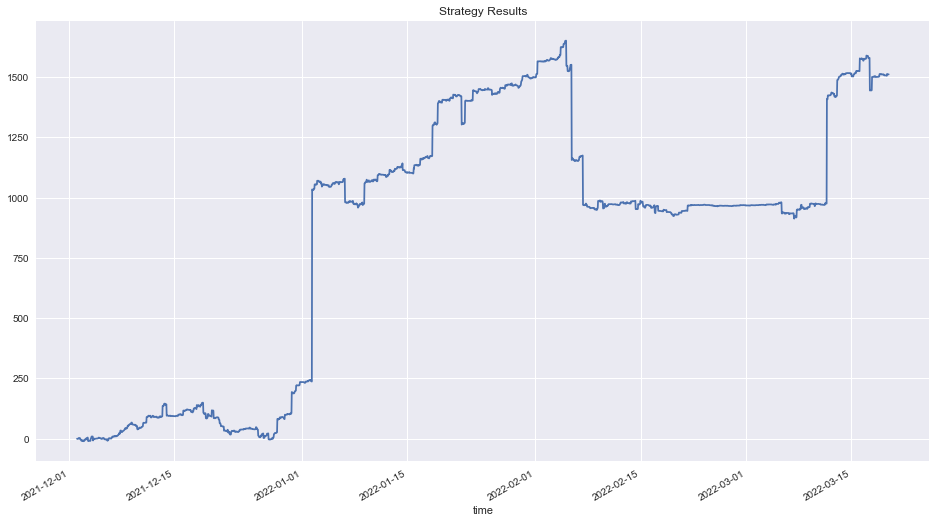

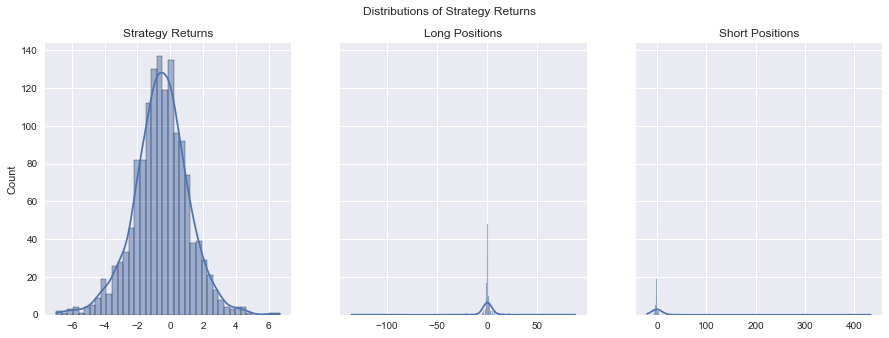

In [16]:
ft.optimize_strategy(param_grid)
ft.plot_results()
ft.plot_diagnostics(no_log = True)

In [17]:
ft.best_params

,random_state,n_estimators,min_samples_split,min_samples_leaf,max_depth
0,41,500,80,10,25
